In [1]:
import pandas as pd
import numpy as np
import os
import keras


%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Model
from keras import layers
from keras import Input
from sklearn.metrics import confusion_matrix,roc_curve, auc,recall_score,precision_score,f1_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-01-03 16:02:35.517366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 参数设置

In [3]:
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False


# from tensorflow import losses

wenben_back=20
total_day=2062
train_num=1650

long_term_back=20
short_term_back=2

wenben_sort=2
batch_size=8
epochs=20
LSTM_num=100
dense_num=20


mix_file='777888.xlsx'
first_columns='search_index'



test_num=total_day-train_num

# 数据转换类，返回多个字典？

In [6]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back,long_term_back,short_term_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back
        self.long_term_back=long_term_back
        self.short_term_back = short_term_back

    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_long_term_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.long_term_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.long_term_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
    def wenben_short_term_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.short_term_back,
                                wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.short_term_back + j),
                                  first_columns:]
            print('文本短期训练array：',samples.shape)
            return samples
    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            print(self.test_num,self.wenben_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_long_term_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                self.long_term_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.long_term_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
    def wenben_short_term_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                self.short_term_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.short_term_back + j),
                             first_columns:]
            print('短期文本测试array：', samples.shape)
            return samples
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.wenben_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target']
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.wenben_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

# 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [8]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back,long_term_back=long_term_back,short_term_back=short_term_back)


# 读取原始数据

In [10]:
new_dir='/Users/ccmac/Documents/毕业论文数据/数据二合为一'
dir='/Users/ccmac/Documents/毕业论文数据/数据区间试验'
# wenben_dir='/Users/ccmac/Documents/毕业论文数据/每日均值'
daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 历史数据标准化函数norm

In [12]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 文本数据标准化函数wenben_norm

In [14]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)
    # media_attention_mean_value = df['media_attention'].mean(axis=0)


    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()
    # media_attention_std_value = df['media_attention'].std()


    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    # x['media_attention'] = (df['media_attention'] - media_attention_mean_value) / media_attention_std_value

    df=x
    return df

# 数据切分

In [16]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

# 进行数据切分

In [18]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1650, 9)
日频测试切分： (412, 9)
十五分钟频训练切分： (26400, 6)
十五分钟频测试切分： (6592, 6)
训练目标切分： (1650, 3)
测试目标切分： (412, 3)


# 调用类中的方法,处理原始数据

In [20]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)

wenben_long_term_train=DM.wenben_long_term_train_data(wenben_norm_train_df)
wenben_short_term_train=DM.wenben_short_term_train_data(wenben_norm_train_df)
wenben_long_term_test=DM.wenben_long_term_test_data(wenben_norm_test_df)
wenben_short_term_test=DM.wenben_short_term_test_data(wenben_norm_test_df)

(1630, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649],
      dtype='int64', length=1650)
日频训练array： (1630, 20, 5)
412 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_86161/3293293578.py:129: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == j, 'target']
/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_86161/3293293578.py:139: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j


训练标签array (1630,)
(392,)
文本长期训练array： (1630, 20, 2)
文本短期训练array： (1630, 2, 2)
长期文本测试array： (392, 20, 2)
短期文本测试array： (392, 2, 2)


# 构建神经网络模型

In [22]:
def my_model(long_term_back,short_term_back,wenben_sort):

    ##### 一、模型搭建

    # 文本输入训练(!!!卷积滤镜行列先后)
    wenben_long_term_input=Input(shape=(long_term_back,wenben_sort),dtype='float32',name='wenben_long_term_input')
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(wenben_long_term_input)
    LSTM_long_term=layers.LSTM(LSTM_num)(Conv1D_fif)
    wenben_short_term_input = Input(shape=(short_term_back,wenben_sort), dtype='float32', name='wenben_short_term_input')
    Conv1D_fif = layers.Conv1D(16, 1, strides=1)(wenben_short_term_input)
    LSTM_short_term = layers.LSTM(LSTM_num)(Conv1D_fif)
    # 15分钟频输入训练(!!!卷积滤镜行列先后)
    fif_min_input=Input(shape=(16,5),dtype='float32',name='fif_min_input')
    # fif_min_input=(8,16,4,1)
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(fif_min_input)
    LSTM_fif=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 日频输入训练
    daily_input=Input(shape=(20,5),dtype='float32',name='daily_input')
    # daily_input=(8,16,4,1)
    Conv1D_daily=layers.Conv1D(16,1,strides=1)(daily_input)
    LSTM_daily=layers.LSTM(LSTM_num)(Conv1D_daily)
    # 15分钟频训练结果和日频训练结果合并
    concatenated=layers.concatenate([LSTM_fif,LSTM_daily,LSTM_long_term,LSTM_short_term],axis=-1) # axis=-1按照最后一个轴粘合

    alloy=layers.Dense(dense_num,activation='relu')(concatenated) #将粘合结果再接一个全连接层
    dropout=layers.Dropout(0.2)(alloy)
    output=layers.Dense(1,activation='sigmoid')(dropout)
    model=Model([fif_min_input,daily_input,wenben_long_term_input,wenben_short_term_input],output) #八股文：将输入和输出圈起来

    print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])
    return model
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')


# 模型滞后时长赋值

In [24]:
model=my_model(long_term_back=long_term_back,short_term_back=short_term_back,wenben_sort=wenben_sort)


2025-01-03 16:02:47.442772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:02:47.445509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:02:47.446684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fif_min_input (InputLayer)     [(None, 16, 5)]      0           []                               
                                                                                                  
 daily_input (InputLayer)       [(None, 20, 5)]      0           []                               
                                                                                                  
 wenben_long_term_input (InputL  [(None, 20, 2)]     0           []                               
 ayer)                                                                                            
                                                                                                  
 wenben_short_term_input (Input  [(None, 2, 2)]      0           []                           

2025-01-03 16:02:47.730683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:02:47.732881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:02:47.733693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                                                  
 concatenate (Concatenate)      (None, 400)          0           ['lstm_2[0][0]',                 
                                                                  'lstm_3[0][0]',                 
                                                                  'lstm[0][0]',                   
                                                                  'lstm_1[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 20)           8020        ['concatenate[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 20)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (

/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# model.fit(输入自变量x，因变量y)

In [26]:
history=model.fit(x=[fif_train,daily_train,wenben_long_term_train,wenben_short_term_train],y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/20


2025-01-03 16:02:48.388048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:02:48.389563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:02:48.390563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - ETA: 0s - loss: 0.6986 - acc: 0.5376

2025-01-03 16:02:54.744299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:02:54.746580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:02:54.749999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 8s 22ms/step - loss: 0.6986 - acc: 0.5376 - val_loss: 0.6936 - val_acc: 0.4779
Epoch 2/20
153/153 [==============================] - 2s 13ms/step - loss: 0.6902 - acc: 0.5450 - val_loss: 0.7125 - val_acc: 0.4755
Epoch 3/20
153/153 [==============================] - 2s 12ms/step - loss: 0.6870 - acc: 0.5622 - val_loss: 0.6790 - val_acc: 0.5833
Epoch 4/20
153/153 [==============================] - 2s 12ms/step - loss: 0.6694 - acc: 0.5917 - val_loss: 0.6794 - val_acc: 0.5711
Epoch 5/20
153/153 [==============================] - 2s 13ms/step - loss: 0.6695 - acc: 0.6039 - val_loss: 0.7115 - val_acc: 0.5417
Epoch 6/20
153/153 [==============================] - 2s 15ms/step - loss: 0.6619 - acc: 0.6031 - val_loss: 0.6771 - val_acc: 0.6005
Epoch 7/20
153/153 [==============================] - 2s 15ms/step - loss: 0.6579 - acc: 0.6039 - val_loss: 0.6833 - val_acc: 0.5784
Epoch 8/20
153/153 [==============================] - 2s 14ms/step - loss: 0.656

# model.evaluate(输入测试数据)，进行模型预测性能测试

In [28]:
loss,accuracy = model.evaluate([fif_test,daily_test,wenben_long_term_test,wenben_short_term_test],y=target_test)
print(loss,accuracy)

2025-01-03 16:03:27.751707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:03:27.752420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:03:27.753305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 1s 4ms/step - loss: 0.8186 - acc: 0.6097
0.8185950517654419 0.6096938848495483


# 构建y的函数

In [30]:
def gen_y_pred():
    y_predict=model.predict([fif_test,daily_test,wenben_long_term_test,wenben_short_term_test],batch_size=1).reshape(test_num-wenben_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [32]:
y_pred=gen_y_pred()
print(y_pred)

2025-01-03 16:03:28.668300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:03:28.669385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:03:28.670143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

392/392 [==============================] - 1s 1ms/step
[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

#  构建使用测试集作为回测数据的类

In [34]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back,wenben_back):
        self.train_num=train_num
        self.daily_back=daily_back
        self.wenben_back = wenben_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.wenben_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [36]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20,wenben_back=wenben_back)

# 

In [38]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [39]:
back_df=split_back_trader()['daily_test_df']

In [40]:
back_df

,指数代码,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1650,300,2019-10-24,3877.924,3890.196,3852.583,3870.668,0.016182,1269,0.596683
1651,300,2019-10-25,3871.769,3899.722,3849.034,3896.792,0.085780,1191,0.632760
1652,300,2019-10-28,3904.982,3927.796,3897.818,3926.585,0.257604,1287,0.581904
1653,300,2019-10-29,3929.708,3932.375,3910.226,3910.226,-0.155524,1342,0.616206
1654,300,2019-10-30,3904.717,3908.100,3883.447,3891.226,-0.053298,1202,0.523138
...,...,...,...,...,...,...,...,...,...
2057,300,2021-06-28,5253.608,5260.637,5226.220,5251.760,-0.140303,3708,0.703872
2058,300,2021-06-29,5248.525,5248.525,5182.677,5190.545,-0.060294,3675,0.630577
2059,300,2021-06-30,5189.380,5231.426,5186.625,5224.041,-0.171060,3663,0.667921
2060,300,2021-07-01,5241.204,5252.264,5190.876,5229.664,0.226384,4019,0.761491


In [41]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659,
       ...
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061],
      dtype='int64', length=412)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [43]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+20+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+20+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

391
          open     close  rate_of_return  day_rate_of_return
1671  3894.174  3849.995       -0.010182           -0.011345
1672  3850.966  3878.206        0.007328            0.007074
1673  3893.435  3891.653        0.003467           -0.000458
1674  3883.429  3875.619       -0.004120           -0.002011
1675  3877.901  3862.303       -0.003436           -0.004022
...        ...       ...             ...                 ...
2057  5253.608  5251.760        0.002250           -0.000352
2058  5248.525  5190.545       -0.011656           -0.011047
2059  5189.380  5224.041        0.006453            0.006679
2060  5241.204  5229.664        0.001076           -0.002202
2061  5186.661  5081.117       -0.028405           -0.020349

[391 rows x 4 columns]
          open     close  rate_of_return  day_rate_of_return  last_close  \
1670  3894.539  3889.598             NaN           -0.001269         NaN   
1671  3894.174  3849.995       -0.010182           -0.011345    3889.598   
1672  3850.9

# 回测交易逻辑

In [45]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+20 + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+20 + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+20 + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [46]:
result=backtrader(y_pred,backtrader_df)
print(result[1])
print(result[2])
print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


[-0.0012686995816449942, -0.010181771998031719, 0.007327541983820796, 0.003926815646203341, -0.004022279062822931, -0.008707758039698144, 0.0019296513072031285, -0.001784904768148854, 0.003586826415098221, 0.001737008458654321, -0.004459563807070577, 0.009503924930815089, 0.004240300661670249, 4.940381878992817e-05, -0.003695049194573974, -0.0006372513755046327, 0.00809255849696111, 0.0008089939662017098, -0.003906066948170639, -0.005897275369032173, 0.0055167469827683835, -0.004950451021062174, 0.004543442523100127, -0.00028455684773431855, 0.009800909640095279, -0.0033544339327323813, -0.005525687333736484, 0.0019398886513992686, 0.009314082438301119, -0.030985512584793873, -0.07880889162843929, 0.026374880095695552, 0.004084120034720806, 0.00523668577281966, -0.007050236815646982, -0.006512244736163519, 0.0070241335744494204, 0.0029884139714433378, -0.003027397691108602, -0.0019531678410730224, 0.02012332579437781, 0.0011663211615149383, -0.00401278229372759, -0.002174050331987254, 

In [47]:
returns=result[3]
returns = [ret - 1 for ret in returns]
returns

[-0.0012686995816449942,
 -0.011437553969802394,
 -0.004193821142887577,
 -0.00028347385916549506,
 -0.004304612711019895,
 -0.01297488722477591,
 -0.011070272925666869,
 -0.012835418310885971,
 -0.009294630313234076,
 -0.007573766706053919,
 -0.011999554817239022,
 -0.002609672754610215,
 0.0016195621099519553,
 0.001669045941294911,
 -0.002032170460140148,
 -0.0026681268322238383,
 0.005402839692270289,
 0.0062162045231834995,
 0.0022858566639818445,
 -0.0036248990312519602,
 0.0018718503007228993,
 -0.003087867223571794,
 0.001441545752279172,
 0.0011565787028298136,
 0.010968823866283284,
 0.007577595738571752,
 0.002010036980042429,
 0.0039538248793682396,
 0.013304733568542337,
 -0.018093033005676884,
 -0.09547603275674199,
 -0.07161932157701822,
 -0.06782770344842326,
 -0.06294621004525502,
 -0.0695526611734355,
 -0.07561196195798614,
 -0.06911893690415583,
 -0.06633707892944818,
 -0.06916364790097085,
 -0.0709817275291924,
 -0.052286790163332264,
 -0.05118145219165249,
 -0.0549

In [48]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -97.93%


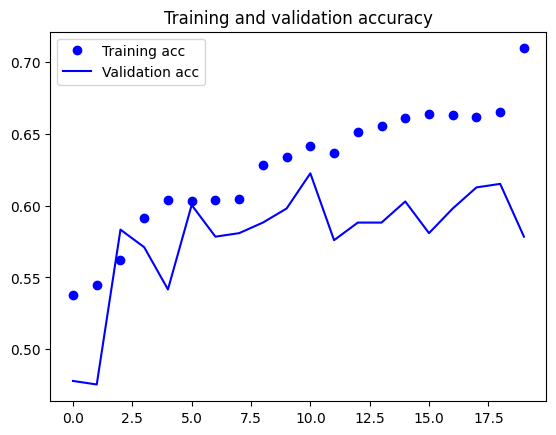

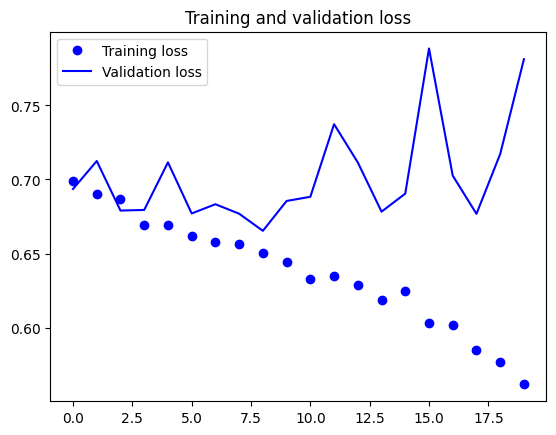

In [49]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [51]:
confusion_matrix = confusion_matrix(target_test, y_pred,labels=[1,0])
precision_score=precision_score(target_test, y_pred)
recall_score=recall_score(target_test, y_pred)
f1_score=f1_score(target_test, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[160  57]
 [ 96  79]]
查准率： 0.625
查全率： 0.7373271889400922
f1-score: 0.6765327695560254


2025-01-03 16:03:30.599437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-03 16:03:30.600310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-03 16:03:30.601124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 1s 4ms/step


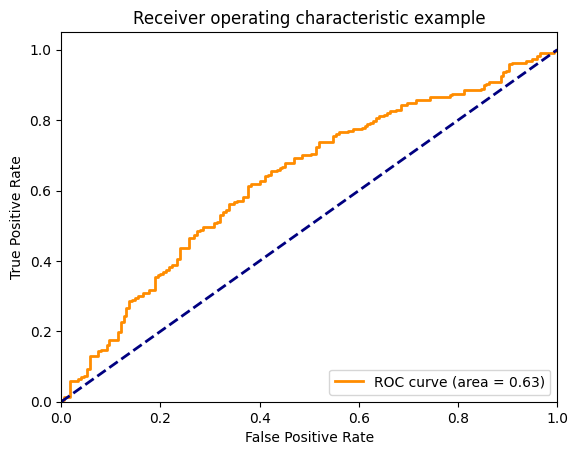

In [52]:
y_predict=model.predict([fif_test,daily_test,wenben_long_term_test,wenben_short_term_test]).reshape(test_num-wenben_back).tolist()
fpr,tpr,threshold = roc_curve(target_test, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [54]:
df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
df10=pd.DataFrame({'每日收益率':result[1]})
path9='/Users/ccmac/Desktop'
df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [55]:
import numpy as np
t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
y = np.cumprod(t, axis=1)
print(t)
print(y)


[[1 2 3 4]
 [5 6 7 8]]
[[   1    2    6   24]
 [   5   30  210 1680]]
